In [3]:
# Google Colabでkaggle.jsonをアップロード
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kojikojipro","key":"04c6e3329de941099c00e7a9a89a384a"}'}

In [0]:
# Google Colabでkaggle.jsonをフォルダ移動
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Google Colabでデータセットをダウンロード
!pip install kaggle
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 39.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 295kB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 4.32MB/s]


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

In [2]:
# data_folder = '../data/'  # Local環境
data_folder = ''    #Google Colab
train = pd.read_csv(data_folder + 'train.csv')
test = pd.read_csv(data_folder + 'test.csv')

# テストデータの'PassengerId'を取得しておく
passenger_id = test.loc[:, 'PassengerId']

# 表示
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [0]:
# 'Cabin"のデータはNanを0、それ以外を1に置き換える
def cabin_encode(data):
    data['Cabin'] = data['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
    return data


# カテゴリ変数をLabel Encoding
def labeling(data, cat_cols):
    for cat in cat_cols:
        cat_i = data.columns.get_loc(cat)
        labels, _ = pd.factorize(data.iloc[:, cat_i])
        for i in range(len(labels)):
            data.iat[i, cat_i] = labels[i]

    return data


def standard(data, num_cols):
    # 数値データのNanを0に置き換える
    data[num_cols] = data[num_cols].fillna(0)
    # 数値データを正規化
    scaler = StandardScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])

    return data


ans_col = ['Survived']
cat_cols = ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
num_cols = list(set(train.columns) - set(ans_col + cat_cols))
train = cabin_encode(train)
train = labeling(train, cat_cols)
train = standard(train, num_cols)

cat_cols = ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
num_cols = list(set(test.columns) - set(cat_cols))
test = cabin_encode(test)
test = labeling(test, cat_cols)
test = standard(test, num_cols)

In [0]:
# IDと名前はユニークなデータなので削除
# Ticketはダブリが少ないので削除
del_cols = ['PassengerId', 'Name', 'Ticket']

# トレーニングデータを分割
train_x = train.drop(del_cols + ans_col, axis=1)
train_y = train.loc[:, ans_col]

# テストデータの必要のないカラムを削除
test = test.drop(del_cols, axis=1)

# カテゴリ変数と正解データをOne Hot Encoding
cat_cols = list(set(cat_cols) - set(del_cols))
train_x = pd.get_dummies(train_x, columns=cat_cols)
train_y = pd.get_dummies(train_y, columns=ans_col)
test = pd.get_dummies(test, columns=cat_cols)

In [5]:
# トレインデータ確認
train_x

,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Cabin_0,Cabin_1,Embarked_-1,Embarked_0,Embarked_1,Embarked_2,Pclass_0,Pclass_1,Pclass_2
0,-0.102313,0.432793,-0.473674,-0.502445,1,0,1,0,0,1,0,0,1,0,0
1,0.807492,0.432793,-0.473674,0.786845,0,1,0,1,0,0,1,0,0,1,0
2,0.125138,-0.474545,-0.473674,-0.488854,0,1,1,0,0,1,0,0,1,0,0
3,0.636903,0.432793,-0.473674,0.420730,0,1,0,1,0,1,0,0,0,1,0
4,0.636903,-0.474545,-0.473674,-0.486337,1,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.182001,-0.474545,-0.473674,-0.386671,1,0,1,0,0,1,0,0,0,0,1
887,-0.272901,-0.474545,-0.473674,-0.044381,0,1,0,1,0,1,0,0,0,1,0
888,-1.353294,0.432793,2.008933,-0.176263,0,1,1,0,0,1,0,0,1,0,0
889,0.125138,-0.474545,-0.473674,-0.044381,1,0,0,1,0,0,1,0,0,1,0


In [6]:
# テストデータ確認
test

,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Cabin_0,Cabin_1,Embarked_0,Embarked_1,Embarked_2,Pclass_0,Pclass_1,Pclass_2
0,0.594801,-0.499470,-0.400248,-0.496637,1,0,1,0,1,0,0,1,0,0
1,1.305896,0.616992,-0.400248,-0.511497,0,1,1,0,0,1,0,1,0,0
2,2.159209,-0.499470,-0.400248,-0.463335,1,0,1,0,1,0,0,0,1,0
3,0.168145,-0.499470,-0.400248,-0.481704,1,0,1,0,0,1,0,1,0,0
4,-0.116293,0.616992,0.619896,-0.416740,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-1.367819,-0.499470,-0.400248,-0.492680,1,0,1,0,0,1,0,1,0,0
414,0.850795,-0.499470,-0.400248,1.314641,0,1,0,1,0,0,1,0,0,1
415,0.822352,-0.499470,-0.400248,-0.507017,1,0,1,0,0,1,0,1,0,0
416,-1.367819,-0.499470,-0.400248,-0.492680,1,0,1,0,0,1,0,1,0,0


In [0]:
# トレインデータに'Embarked_-1'があったので列を削除
train_x = train_x.drop('Embarked_-1', axis=1)

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def to_cuda(obj):
    if torch.cuda.is_available():
        return obj.cuda()
    return obj

In [0]:
input_size = len(train_x.columns)
outpu_size = len(train_y.columns)

train_x = torch.FloatTensor(np.array(train_x))
train_x = to_cuda(train_x)
train_y = torch.FloatTensor(np.array(train_y))
train_y = to_cuda(train_y)

In [10]:
HIDDEN_SIZE = 32
EPOCH_NUM = 300
BATCH_SIZE = 10

train = data.TensorDataset(train_x, train_y)
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

net = Net(input_size, HIDDEN_SIZE, outpu_size)
net = to_cuda(net)
print(net)

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

Net(
  (fc1): Linear(in_features=14, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


Epoch: 50 | Avearage Loss: 1
Epoch: 100 | Avearage Loss: 1
Epoch: 150 | Avearage Loss: 1
Epoch: 200 | Avearage Loss: 1
Epoch: 250 | Avearage Loss: 1
Epoch: 300 | Avearage Loss: 0


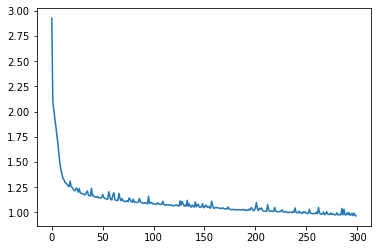

In [11]:
# 学習
loss_log = []
for e in range(EPOCH_NUM):
    total_loss = 0
    for x, y in train_loader:
        x, y = Variable(x), Variable(y)
        optimizer.zero_grad()
        output = net(x)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    ave_loss = total_loss / BATCH_SIZE
    loss_log.append(ave_loss)

    if (e + 1) % 50 == 0:
        print('Epoch: %d | Avearage Loss: %d' % (e + 1, ave_loss))

plt.plot([i for i in range(len(loss_log))], loss_log)

In [0]:
test = torch.FloatTensor(np.array(test))
test = to_cuda(test)
test = Variable(test)

net.eval()
result = torch.max(net(test).data, 1)[1]

In [0]:
# Google ColabでSubmit用ファイル保存
submission = pd.DataFrame()
submission['PassengerId'] = passenger_id
submission['Survived'] = result.data.numpy()
submission.to_csv('titanic_submission.csv', index=False)